In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Open and read the text file
with open('ex5data.txt', 'r') as file:
    lines = file.readlines()

# Split each line by commas and create a list of lists
split_data = [line.strip().split(',') for line in lines]

# Convert the split data into a list of tuples with numeric values
numeric_data = [(float(row[0]), float(row[1]), float(row[2])) for row in split_data]

# Specify column names
column_names = ['x1', 'x2', 'y']

# Create a Polars DataFrame with specified schema
data = pl.DataFrame(numeric_data, schema=[(col, pl.Float64) for col in column_names], orient="row")

columns = data.columns
n = len(columns)-1
m  = len(data)
x = data.select(columns[:n])
y = data.select(columns[-1])

Text(0.5, 1.0, 'Scatter plot of x1 vs x2 colored by y')

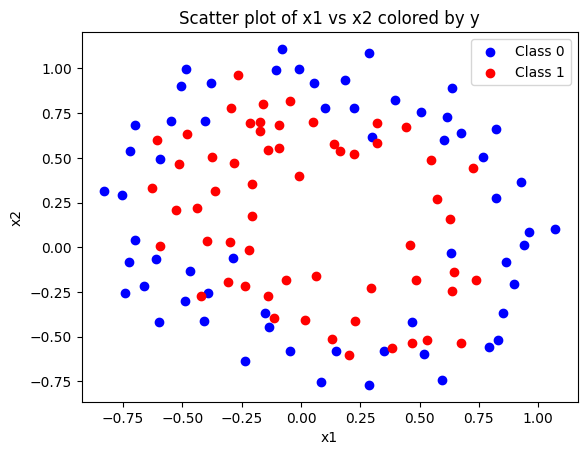

In [3]:
x1 = data['x1'].to_list()
x2 = data['x2'].to_list()
y_list = data['y'].to_list()

plt.figure()
plt.scatter([x1[i] for i in range(len(y_list)) if y_list[i] == 0], [x2[i] for i in range(len(y_list)) if y_list[i] == 0], color='blue', label='Class 0')
plt.scatter([x1[i] for i in range(len(y_list)) if y_list[i] == 1], [x2[i] for i in range(len(y_list)) if y_list[i] == 1], color='red', label='Class 1')

plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.title('Scatter plot of x1 vs x2 colored by y')

In [10]:
degrees = 6
results = []
for d in range(1, degrees+1):
    for i in range(d, -1, -1):
        term = x['x1'] ** i * x['x2'] ** (d - i)
        results.append(term)

# Exclude the first two columns from the results
results = results[2:]

# Convert the accumulated results to Polars Series
for idx in range(len(results)):
    x = x.with_columns(pl.Series(f'res{idx}', results[idx]))

# Display the updated DataFrame
print(x)
columns = x.columns
n = len(columns)

shape: (118, 27)
┌───────────┬───────────┬──────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ x1        ┆ x2        ┆ res0     ┆ res1      ┆ … ┆ res21     ┆ res22     ┆ res23     ┆ res24     │
│ ---       ┆ ---       ┆ ---      ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ f64       ┆ f64       ┆ f64      ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞═══════════╪═══════════╪══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 0.051267  ┆ 0.69956   ┆ 0.002628 ┆ 0.035864  ┆ … ┆ 0.000046  ┆ 0.000629  ┆ 0.008589  ┆ 0.117206  │
│ -0.092742 ┆ 0.68494   ┆ 0.008601 ┆ -0.063523 ┆ … ┆ -0.000256 ┆ 0.001893  ┆ -0.013981 ┆ 0.103256  │
│ -0.21371  ┆ 0.69225   ┆ 0.045672 ┆ -0.147941 ┆ … ┆ -0.003238 ┆ 0.010488  ┆ -0.033973 ┆ 0.110047  │
│ -0.375    ┆ 0.50219   ┆ 0.140625 ┆ -0.188321 ┆ … ┆ -0.006679 ┆ 0.008944  ┆ -0.011978 ┆ 0.01604   │
│ -0.51325  ┆ 0.46564   ┆ 0.263426 ┆ -0.23899  ┆ … ┆ -0.01365  ┆ 0.012384 

In [11]:
mean_x = x.mean()
std_x = x.std()
standardized_x = x.with_columns([(pl.col(col) - mean_x[col]) / std_x[col] for col in columns[:n]])
standardized_x = standardized_x.with_columns(pl.lit(1).alias("constant"))
standardized_x = standardized_x.select(["constant"] + [col for col in standardized_x.columns if col != "constant"])
n
x_mat = standardized_x.to_numpy().reshape(-1, n+1).T
y_mat = y.to_numpy().reshape(-1, 1)

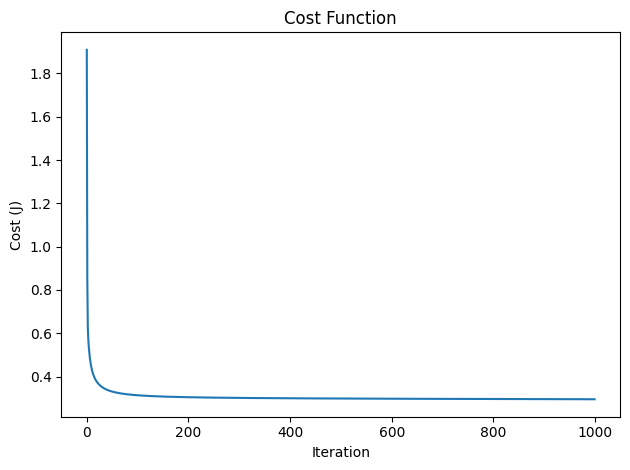

In [15]:
theta = np.random.rand(n+1, 1)
H = 1 / (1 + np.exp(-np.dot(theta.T, x_mat))).T
alpha = 1
loop = 1000
J_values = np.zeros((loop, 1))
for i in range(loop):
    theta = theta - (alpha/m)*np.dot(x_mat, (H-y_mat))
    H = 1 / (1 + np.exp(-np.dot(theta.T, x_mat))).T
    J_values[i] = 1/(m)*(-np.dot(y_mat.T, np.log(H))-np.dot(1-y_mat.T, np.log(1-H)))

standardized_data = standardized_x.with_columns(y)

# Create a figure and a set of subplots
fig, axs = plt.subplots()
# Plot the cost function on the first subplot
axs.plot(J_values)
axs.set_xlabel('Iteration')
axs.set_ylabel('Cost (J)')
axs.set_title('Cost Function')

# Layout so plots do not overlap
fig.tight_layout()